In [2]:
import collections
import dgl 
from dgl.data import FraudAmazonDataset
from sklearn.metrics import accuracy_score, recall_score

In [3]:
from xgnn_src.node.utils import load_data, accuracy, init_teacher, init_graph_student, eval_student, calculate_score, std_normalize
from xgnn_src.shared_networks import MLP, MLP_PRED
from xgnn_src.node.online_kg2 import AllOnlineKG

In [4]:
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [95]:
from interpret.ext.blackbox import TabularExplainer
from raiwidgets import ExplanationDashboard
import shap
from xgnn_src.node.shapley import feature_importance
shap.initjs()

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

In [7]:
def get_class_index(cls, labels, mask):
    idx = ((labels == cls) & mask).nonzero().flatten()
    return idx

def sample_matrix(mat, ratio):
    l = len(mat)
    selected_idx = np.random.choice(np.arange(0, l), (int(l*ratio),), replace=False)
    selected_idx.sort()
    background_samples = mat[selected_idx]
    return background_samples, selected_idx

def balance_training(pos_idx, neg_idx):
    sample_train_neg_idx = np.random.choice(np.arange(0, len(neg_idx)), (len(pos_idx),), replace=False)
    selected_bg_idx = np.concatenate([pos_idx, sample_train_neg_idx])
    selected_bg_idx.sort()
    return selected_bg_idx

In [8]:
Arg = collections.namedtuple("Arg", ["teacher_name", "hidden_sizes", "n_layers", "dropout", "n_hidden"])

## Amazon

In [11]:
amz, amz_num_classes = load_data('amazon', 'net_upu')
amz_test_labels = amz.ndata['label'][amz.ndata['test_mask']]
amz_train_labels = amz.ndata['label'][amz.ndata['train_mask']]
amz_feats = amz.ndata['feat']
amz_feat_size = amz_feats.size()[1]
amz_arg = Arg("graphsage2", [64], 1, 0.5, 32)
amz_base = init_teacher(amz_arg, amz, amz_feat_size, amz_num_classes)
amz_graph_std = init_graph_student("graphsage", amz, amz_feat_size, amz_num_classes, 0.5, n_hidden=32,
                                n_layers=1, hidden_sizes=None)
# amz_graph_std = init_graph_student("gcn", amz, amz_feats, amz_num_classes, 0.5, n_hidden=32,
#                                  n_layers=1, hidden_sizes=None)
amz_mlp = MLP_PRED(amz_feat_size, [64], amz_num_classes, F.relu, 0.5, batch_norm=True, norm_type='bn')
amz_online_mode = AllOnlineKG(amz_base, amz_graph_std, amz_mlp, graph_student_name="graphsage")
model = torch.load('./node/ckpt/graphsage/amz_sl03.pt', map_location='cuda:0')
amz_online_mode.load_state_dict(model)

Done loading data from cached files.
Graph(num_nodes={'user': 11944},
      num_edges={('user', 'net_upu', 'user'): 351216, ('user', 'net_usu', 'user'): 7132958, ('user', 'net_uvu', 'user'): 2073474},
      metagraph=[('user', 'user', 'net_upu'), ('user', 'user', 'net_usu'), ('user', 'user', 'net_uvu')])
net_upu Graph(num_nodes=11944, num_edges=351216,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'feature': Scheme(shape=(25,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(25,), dtype=torch.float32)}
      edata_schemes={})
GraphSAGE2(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.0, inplace=False)
      (fc_self): Linear(in_features=25, out_features=32, bias=False)
      (fc_neigh): Linear(in_features=25, out_features=32, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.0,

<All keys matched successfully>

In [12]:
raw_data = FraudAmazonDataset()
original_feats = raw_data[0].ndata['feature']
std_scaler = StandardScaler()
std_scaler.fit(original_feats.numpy())
original_norm_feats = std_scaler.transform(original_feats.numpy())

Done loading data from cached files.


In [13]:
train_pos_idx = get_class_index(1, amz.ndata['label'], amz.ndata['train_mask'])
train_neg_idx = get_class_index(0, amz.ndata['label'], amz.ndata['train_mask'])
test_pos_idx = get_class_index(1, amz.ndata['label'], amz.ndata['test_mask'])
test_neg_idx = get_class_index(0, amz.ndata['label'], amz.ndata['test_mask'])
selected_bg_idx = balance_training(train_pos_idx.numpy(), train_neg_idx)
selected_test_idx = balance_training(test_pos_idx.numpy(), test_neg_idx)

bg_feats = amz.ndata['feat'][selected_bg_idx]
test_feats = amz.ndata['feat'][selected_test_idx]
full_bg_feats = amz.ndata['feat'][amz.ndata['train_mask']]
full_test_feats = amz.ndata['feat'][amz.ndata['test_mask']]

In [73]:
test_labels = amz.ndata['label'][selected_test_idx]

In [74]:
test_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
# amz_columns = ["#rated_prods", "l_usrname", "#1s_given", "#2s_given", "#3s_given", "#4s_given", "#5s_given",\
#             "%1s_given", "%2s_given", "3s_given", "%4s_given", "%5s_given", "%+rates", "%-rates", \
#             "entrpy_rates", "median_rates", "min_rates", "max_rates", "avg_rates", "min_unhelpful_votes", "day_gap", \
#             "time_entrpy", "same_date_indicator", "l_feback_summary", "sentiment"]
amz_columns = ["RPRD", "LU", "#1S", "#2S", "#3S", "#4S", "#5S",\
            "%1S", "%2S", "3S", "%4S", "%5S", "%PosR", "%NegR", \
            "ETR", "MDR", "MNR", "MXR", "AVGR", "MNUV", "DGP", \
            "TET", "SDI", "LFS", "STM"]
amz_mlp.eval()

MLP_PRED(
  (layers): ModuleList(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=2, bias=True)
  )
  (norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### Using SHAP SamplingExplainer

In [51]:
bg_feat_np = bg_feats.detach().numpy()
test_feat_np = test_feats.detach().numpy()
# https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

In [52]:
test_feat_df = pd.DataFrame(test_feat_np)
test_feat_df.columns = amz_columns

In [53]:
amz_mlp.eval()
shap_explainer, _ = feature_importance(amz_mlp, bg_feats)

In [54]:
shap_values = shap_explainer(test_feat_df)

100%|██████████| 368/368 [06:02<00:00,  1.02it/s]


In [81]:
values = shap_values.values

In [52]:
shap_values2 = shap_explainer(full_test_feats.numpy())

100%|██████████| 1729/1729 [26:49<00:00,  1.07it/s]


In [96]:
shap_values2.feature_names = shap_values.feature_names

In [83]:
values2 = shap_values2.values

### Overall contribution

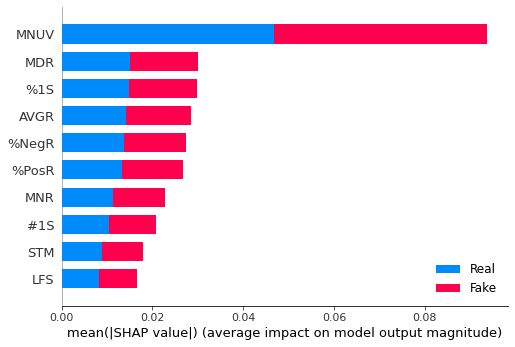

In [84]:
# plt.clf()
shap.summary_plot([values2[:,:,0],values2[:,:,1]], plot_type='bar', feature_names = amz_columns,\
                  class_names=["Real", "Fake"], max_display=10, show=False)
plt.savefig('summary_plot.pdf', format="pdf", dpi=300, bbox_inches="tight")

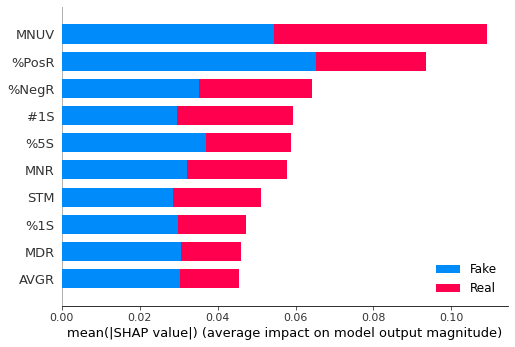

In [86]:
# plt.clf()
shap.summary_plot([values[:,:,0],values[:,:,1]], plot_type='bar', feature_names = amz_columns,\
                  class_names=["Real", "Fake"], max_display=10, show=False)
# plt.savefig('summary_plot.pdf', format="pdf", dpi=300, bbox_inches="tight")

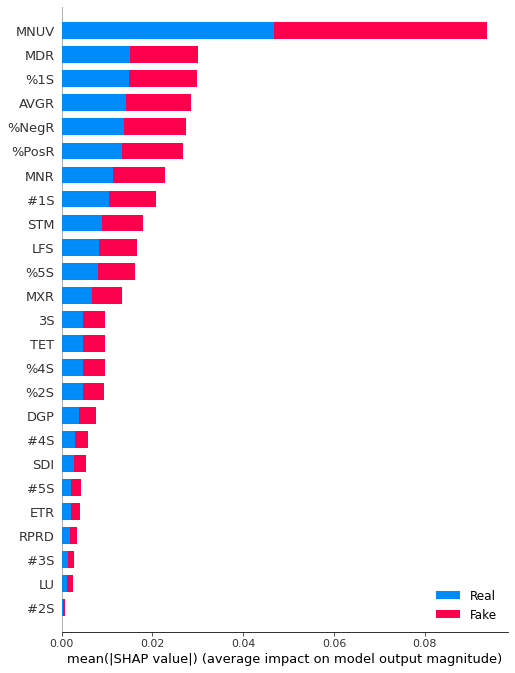

In [87]:
# plt.clf()
shap.summary_plot([values2[:,:,0],values2[:,:,1]], plot_type='bar', feature_names = amz_columns,\
                  class_names=["Real", "Fake"], max_display=25, show=False)
# plt.savefig('summary_plot.pdf', format="pdf", dpi=300, bbox_inches="tight")

In [103]:
order = [
    "MNUV", "MDR", "%1S", "AVGR", "%NegR", "%PosR", "MNR", "#1S", "STM", "LFS",
    "%5S", "MXR", "3S", "TET", "%4S", "%2S", "DGP", "#4S", "SDI", "#5S", "ETR", "RPRD", "#3S", "LU", "#2S"
]
col2num = {col: i for i, col in enumerate(amz_columns)}

order = list(map(col2num.get, order))

In [193]:
# shap_values_rv = copy.deepcopy(shap_values)
# shap_values_rv0 = std_scaler.inverse_transform(shap_values_rv.values[:,:,0])
# shap_values_rv1 = std_scaler.inverse_transform(shap_values_rv.values[:,:,1])
# shap_values_rv.values = np.swapaxes(np.array([shap_values_rv0, shap_values_rv1]), 0, 2)
# shap_values_rv.values = np.swapaxes(shap_values_rv.values, 0, 1)
# shap_values_rv.data = std_scaler.inverse_transform(shap_values_rv.data)

In [104]:
order

### Fake reviews

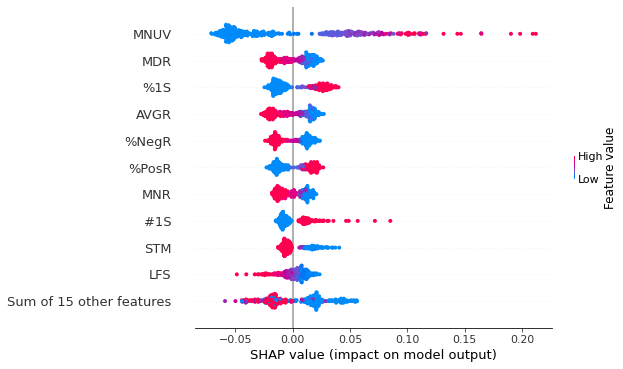

In [106]:
plt.clf()
shap.plots.beeswarm(shap_values[:,:,1], max_display=11, show=False, order=order)
# plt.gcf().axes[-1].set_aspect(100)
# plt.gcf().axes[-1].set_box_aspect(100)
# plt.savefig("fake_contribution.pdf", format="pdf", dpi=300, bbox_inches="tight")

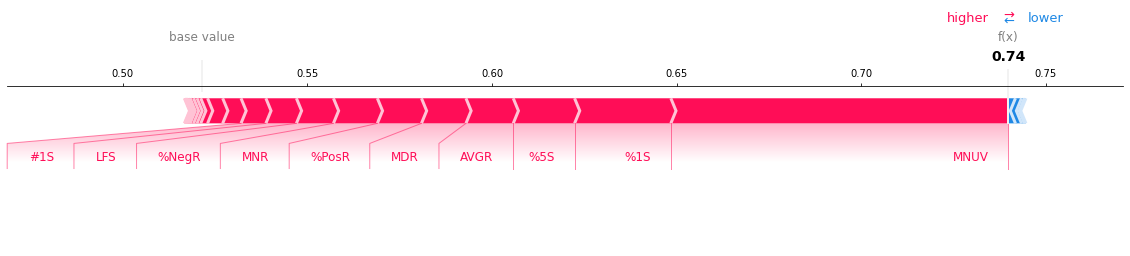

In [107]:
cls = 1
shap.force_plot(shap_values.base_values[cls], shap_values.values[-3,:,cls], feature_names=amz_columns, matplotlib=True, show=False)
plt.savefig("fake_example.pdf", format="pdf", dpi=300, bbox_inches="tight")

### Real reviews

In [102]:
plt.clf()
shap.plots.beeswarm(shap_values[:,:,0], max_display=11, show=False, order=order)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig("real_contribution.pdf", format="pdf", dpi=300, bbox_inches='tight')

NameError: name 'order' is not defined

<Figure size 720x720 with 0 Axes>

In [97]:
cls = 0
shap.force_plot(shap_values.base_values[cls], shap_values.values[10,:,cls], feature_names=amz_columns, show=False)
plt.savefig("real_example.pdf", format="pdf", dpi=300, bbox_inches="tight")

<Figure size 720x720 with 0 Axes>

### Using SHAP deep explainer 1

In [15]:
# deep_explainer includes eval()
deep_explainer = shap.DeepExplainer(amz_mlp, bg_feats)

In [16]:
s = time.time()
deep_shap_values = deep_explainer.shap_values(full_test_feats)
print("execute time on %i samples:" % len(full_test_feats), time.time() - s)
deep_shap_values = np.array(deep_shap_values).transpose((1,2,0))
deep_explanations = shap.Explanation(deep_shap_values, data=full_test_feats, feature_names=amz_columns)

execute time on 1729 samples: 69.70221734046936


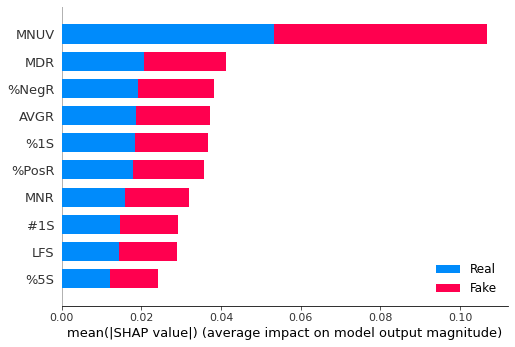

In [17]:
# plt.clf()
shap.summary_plot([deep_shap_values[:,:,0],deep_shap_values[:,:,1]], plot_type='bar', feature_names = amz_columns,\
                  class_names=["Real", "Fake"], max_display=10)
# plt.savefig('test.png')

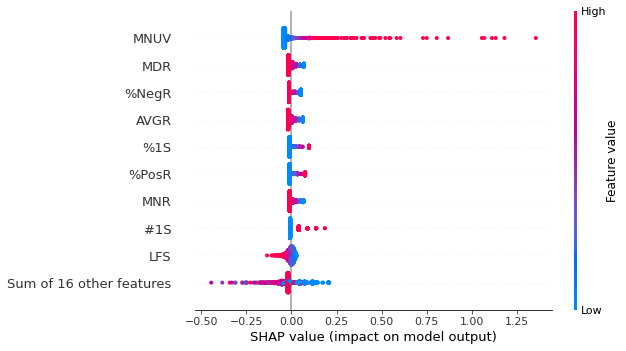

In [18]:
shap.plots.beeswarm(deep_explanations[:,:,1], max_display=10, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

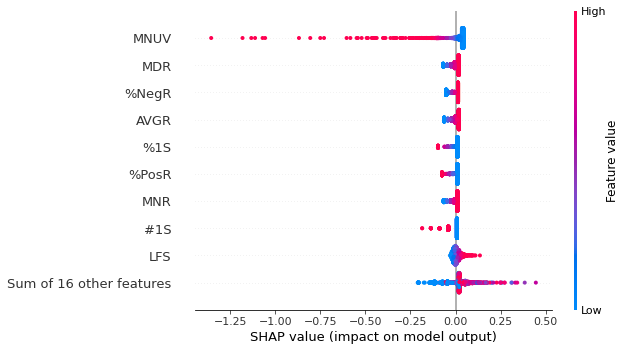

In [19]:
shap.plots.beeswarm(deep_explanations[:,:,0], max_display=10, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

In [96]:
cls = 1
shap.force_plot(deep_explainer.expected_value[cls], deep_shap_values[7,:,cls], feature_names=amz_columns)

In [37]:
deep_explainer.expected_value

array([0.452353, 0.547647], dtype=float32)

## Deep value 2

In [21]:
s = time.time()
deep_shap_values2 = deep_explainer.shap_values(test_feats)
print("execute time on %i samples:" % len(test_feats), time.time() - s)
deep_shap_values2 = np.array(deep_shap_values2).transpose((1,2,0))
deep_explanations2 = shap.Explanation(deep_shap_values2, data=test_feats, feature_names=amz_columns)

execute time on 368 samples: 15.342943906784058


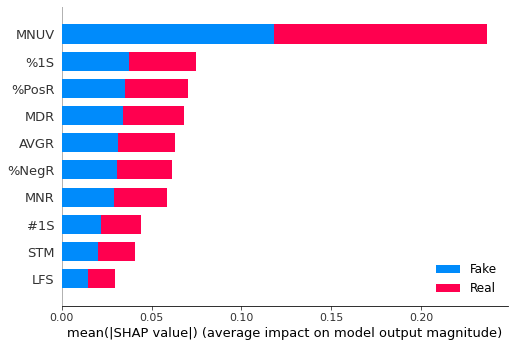

In [22]:
# plt.clf()
shap.summary_plot([deep_shap_values2[:,:,0],deep_shap_values2[:,:,1]], plot_type='bar', feature_names = amz_columns,\
                  class_names=["Real", "Fake"], max_display=10)
# plt.savefig('test.png')

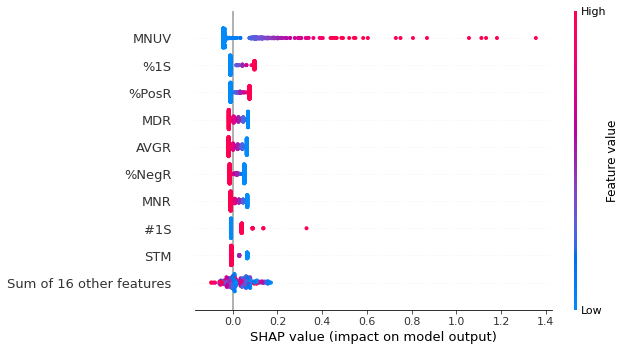

In [23]:
shap.plots.beeswarm(deep_explanations2[:,:,1], max_display=10, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

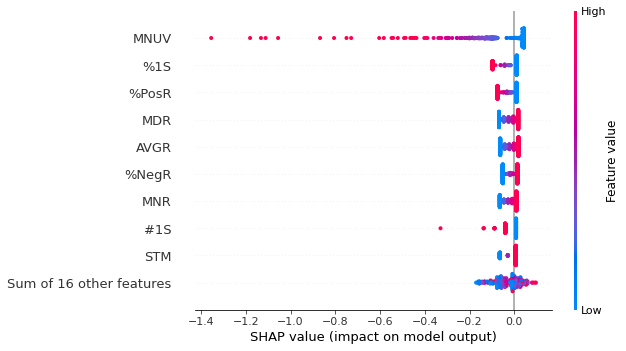

In [24]:
shap.plots.beeswarm(deep_explanations2[:,:,0], max_display=10, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)